In [0]:
!pip install transformers

     |████████████████████████████████| 573kB 3.4MB/s 
     |████████████████████████████████| 3.7MB 48.7MB/s 
     |████████████████████████████████| 890kB 43.3MB/s 
     |████████████████████████████████| 1.0MB 31.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=727771666ad5858a668b8b82538cfd381c5bc2f3e1c7c676c7664bab97dc6b63
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import (
    AdamW,
    BertConfig,
    BertTokenizer,
    BertForSequenceClassification,
    XLNetConfig, 
    XLNetForSequenceClassification, 
    XLNetTokenizer,
    XLMConfig, 
    XLMForSequenceClassification, 
    XLMTokenizer,
    RobertaConfig, 
    RobertaForSequenceClassification, 
    RobertaTokenizer,
    DistilBertConfig, 
    DistilBertForSequenceClassification, 
    DistilBertTokenizer,
    AlbertConfig, 
    AlbertForSequenceClassification, 
    AlbertTokenizer,
    XLMRobertaConfig, 
    XLMRobertaForSequenceClassification, 
    XLMRobertaTokenizer,
    get_linear_schedule_with_warmup
)


In [0]:
MODEL_CLASSES = {
    "bert": (BertConfig, BertForSequenceClassification, BertTokenizer),
    "xlnet": (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    "xlm": (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    "roberta": (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer),
    "albert": (AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer),
    "xlmroberta": (XLMRobertaConfig, XLMRobertaForSequenceClassification, XLMRobertaTokenizer),
} 

In [0]:
## Model setup
model_type = 'xlmroberta'
model_name = 'xlm-roberta-base'
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

config = config_class.from_pretrained(model_name, num_labels=50)
model = model_class.from_pretrained(model_name, config=config)
tokenizer = tokenizer_class.from_pretrained(model_name, do_lower_case=False)


In [0]:
# PARAMETERS
MAX_LEN = 512
batch_size = 4
lr = 4e-5
eps = 1e-8
epochs = 4

In [0]:
ROOT = ""
DATA_PATH = ROOT + 'datasets/'
def get_data(subset='train'):
    texts = []
    for root, folders, files in os.walk(DATA_PATH + '/C50/C50{}'.format(subset)):
        if len(files) == 0:
            continue

        author = root.split('/')[-1]
        for file in files:
            if file.endswith('.txt'):
                with open(os.path.join(root, file), 'r') as f:
                    texts.append({
                        'author': author,
                        'text': f.read(),

                    })
    df = pd.DataFrame(texts)
    unique_authors = sorted(df['author'].unique())
    num_authors = len(unique_authors)
    author_to_id = { unique_authors[i]: i for i in range(num_authors) }
    df = df.assign(author_id=df['author'].apply(lambda a: author_to_id[a]))
    return df

In [0]:
def get_encodings(texts):
    token_ids = []
    attention_masks = []
    for text in texts:
        token_id = tokenizer.encode(text, 
                                    add_special_tokens=True, 
                                    max_length=MAX_LEN,
                                    pad_to_max_length=True)
        token_ids.append(token_id)
    return token_ids



def get_attention_masks(padded_encodings):
    attention_masks = []
    for encoding in padded_encodings:
        attention_mask = [int(token_id > 0) for token_id in encoding]
        attention_masks.append(attention_mask)
    return attention_masks

In [0]:
# train_df = get_data()
# test_df = get_data('test')

# train_df.to_pickle(ROOT + 'reuters50_train.pkl')
# test_df.to_pickle(ROOT + 'reuters50_test.pkl')

In [0]:
train_df = pd.read_pickle(DATA_PATH + 'reuters50_train.pkl')
test_df = pd.read_pickle(DATA_PATH + 'reuters50_test.pkl')

In [0]:
train_encodings = get_encodings(train_df.text.values)
train_attention_masks = get_attention_masks(train_encodings)

test_encodings = get_encodings(test_df.text.values)
test_attention_masks = get_attention_masks(test_encodings)


In [0]:
train_input_ids = torch.tensor(train_encodings)
train_masks = torch.tensor(train_attention_masks)
train_labels = torch.tensor(train_df.author_id.values)


test_input_ids = torch.tensor(test_encodings)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_df.author_id.values)

# Create the DataLoader for our training set.
train_data = TensorDataset(train_input_ids, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(test_input_ids, test_masks, test_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Tell pytorch to run this model on the GPU.
model.to(device)

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(), lr=lr, eps=eps)



In [0]:
import math

total_steps = len(train_dataloader) * epochs
warmup_steps = math.ceil(total_steps * 0.06)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [0]:
import math 

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def get_confusion_matrix(preds, labels):
    """
    Rows = true labels
    Columns = classified labels
    """
    confusion_matrix = np.zeros((50, 50))
    preds = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    for i, label in enumerate(labels):
        pred = preds[i]
        confusion_matrix[label][pred] += 1

    return confusion_matrix

def parse_confusion_matrix(confusion_matrix):
    """
    Rows = labels
    Col0 = tp
    Col1 = fp
    Col2 = fn
    Col3 = tn
    """
    parsed_confusion_matrix = np.zeros((50, 4))
    for i in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[i][i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp 
        tn = confusion_matrix.sum() - tp - fp - fn
        # print(f'Label: {i}, tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}')
        parsed_confusion_matrix[i][0] = tp
        parsed_confusion_matrix[i][1] = fp
        parsed_confusion_matrix[i][2] = fn
        parsed_confusion_matrix[i][3] = tn
    return parsed_confusion_matrix

def calculate_avg_precision(parsed_confusion_matrix):
    """
    Calculates macro average precision
    """
    total_precision = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, fp, _, _ = parsed_confusion_matrix[i]
        precision = tp / (tp + fp)
        if not np.isnan(precision):
            total_precision += precision
    return total_precision / num_classes

def calculate_avg_recall(parsed_confusion_matrix):
    """
    Calculates macro average recall
    """
    total_recall = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, _, fn, _ = parsed_confusion_matrix[i]
        recall = tp / (tp + fn)
        if not np.isnan(recall):
            total_recall += recall
    return total_recall / num_classes

def calculate_avg_f1(parsed_confusion_matrix):
    """
    Calculates macro average f1 score
    """
    total_f1 = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, fp, fn, _ = parsed_confusion_matrix[i]
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2*((precision * recall) / (precision + recall))
        if not np.isnan(f1):
            total_f1 += f1
    return total_f1 / num_classes

def calculate_avg_mcc(parsed_confusion_matrix):
    """
    Calculates macro average Matthews correlation coefficient
    """
    total_mcc = 0
    num_classes = parsed_confusion_matrix.shape[0]
    for i in range(num_classes):
        tp, fp, fn, tn = parsed_confusion_matrix[i]
        mcc = (tp * tn - fp * fn) / math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        if not np.isnan(mcc):
            total_mcc += mcc
    return total_mcc / num_classes

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
# ========================================
#               Training
# ========================================

train_loss_values = []
eval_loss_values = []

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    train_loss, train_accuracy = 0, 0
    model.train()
    
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_texts = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_authors = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_texts, 
                        attention_mask=b_attention_masks, 
                        labels=b_authors)
        
        loss = outputs[0]
        logits = outputs[1]

        logits = outputs[1].detach().cpu().numpy()
        author_ids = b_authors.detach().cpu().numpy()
        
        # print("epoch: {}, pred: {}, label: {}".format(epoch_i, np.argmax(logits, axis=1), labels))
        train_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.
        tmp_train_accuracy = flat_accuracy(logits, author_ids)
        
        # Accumulate the total accuracy.
        train_accuracy += tmp_train_accuracy

        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()

        scheduler.step()

    avg_train_loss = train_loss / len(train_dataloader)   
    avg_train_accuracy = train_accuracy / len(train_dataloader)        
    
    # Store the loss value for plotting the learning curve.
    train_loss_values.append(avg_train_loss)

    print("")
    print("  Accuracy: {0:.3f}".format(avg_train_accuracy))
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    confusion_matrix = np.zeros((50, 50))

    for batch in validation_dataloader:
        
        b_texts = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_authors = batch[2].to(device)
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_texts, 
                            attention_mask=b_attention_masks,
                            labels=b_authors
                            )
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        loss = outputs[0]
        logits = outputs[1]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        author_ids = b_authors.to('cpu').numpy()
        # print("Pred: {}, label: {}".format(np.argmax(logits, axis=1).flatten(), author_ids.flatten()))

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, author_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        eval_loss += loss.item()

        tmp_confusion_matrix = get_confusion_matrix(logits, author_ids)
        confusion_matrix += tmp_confusion_matrix

    avg_eval_loss = eval_loss / len(validation_dataloader)
    avg_eval_accuracy = eval_accuracy / len(validation_dataloader)

    eval_loss_values.append(avg_eval_loss)

    parsed_confusion_matrix = parse_confusion_matrix(confusion_matrix)
    avg_precision = calculate_avg_precision(parsed_confusion_matrix)
    avg_recall = calculate_avg_recall(parsed_confusion_matrix)
    avg_f1 = calculate_avg_f1(parsed_confusion_matrix)
    avg_mcc = calculate_avg_mcc(parsed_confusion_matrix)

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.3f}".format(avg_eval_accuracy))
    print("  Average eval loss: {0:.3f}".format(avg_eval_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("  Average precision: {0:.3f}".format(avg_precision))
    print("  Average recall: {0:.3f}".format(avg_recall))
    print("  Average F1: {0:.3f}".format(avg_f1))
    print("  Average MCC: {0:.3f}".format(avg_mcc))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


KeyboardInterrupt: ignored

In [0]:
model_filename = f'{model_type}_{model_name}_max-length={MAX_LEN}.pth'
torch.save(model.state_dict(), ROOT + "/models/" + model_filename)

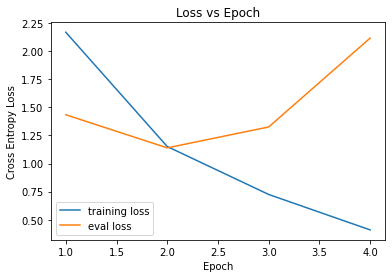

In [0]:
import matplotlib.pyplot as plt
x = np.arange(1, epochs+1)
fig, ax = plt.subplots(1, 1)
ax.plot(x, train_loss_values, label="training loss")
ax.plot(x, eval_loss_values, label="eval loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Loss vs Epoch")
ax.legend()
